In [22]:
import numpy as np
from nltk.tokenize import TweetTokenizer
import pandas as pd
import tensorflow as tf
import gensim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.python.keras.layers import Layer
from tensorflow.keras import initializers, regularizers, constraints

In [23]:
"""
Loading the Google_word2_vec model
"""
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)  
print(len(word2vec_model.vocab), ' words loaded!!')

3000000  words loaded!!


In [24]:
"""
Read input csv files
"""
def get_input_data(input_filename):
    dataDF = pd.read_csv(input_filename, sep=',', encoding='ISO-8859-1')
    return dataDF


In [25]:
"""
Get vectorized representation of a words in a sentence using the word2vec model
"""
def get_vec_representation_of_text_from_word2Vec(input_text, word2vec_model, word_limit, vector_dimension):
    tw = TweetTokenizer()
    tokens = tw.tokenize(input_text)
    tokens = tokens[:word_limit]
    
    embedding_matrix = np.zeros([word_limit, vector_dimension])
    for index, token in enumerate(tokens):
        if token in word2vec_model.vocab:
            embedding_vector = word2vec_model[token]
            embedding_matrix[index] = embedding_vector[:vector_dimension]
        else:
            embedding_matrix[index] = np.zeros(vector_dimension)
                
    return embedding_matrix


In [26]:
train_dataset_path = './train.csv'
test_dataset_path = './test.csv'
glove_embedding_vector_dim = 300
word_limit = 50
"""
Extracting training dataset: 
"""
dataDF = get_input_data(train_dataset_path)
# dataDF_2 = get_input_data(train_dataset_path_2)
# dataDF = pd.concat([dataDF, dataDF_2])
tweet_text = dataDF['Tweet']
target_train_text = dataDF['Target']
trainY = dataDF['Stance']

"""
Extracting test dataset: 
"""
test_dataDF = get_input_data(test_dataset_path)
test_tweet_text = test_dataDF['Tweet']
target_test_text = test_dataDF['Target']
testY = test_dataDF['Stance']

trainX = []
train_targetX = []

testX = []
test_targetX = []

for sentence in tweet_text:
    trainX.append(get_vec_representation_of_text_from_word2Vec(sentence, word2vec_model, word_limit=word_limit,
                                                        vector_dimension=glove_embedding_vector_dim))

for sentence in test_tweet_text:
    testX.append(get_vec_representation_of_text_from_word2Vec(sentence, word2vec_model, word_limit=word_limit,
                                                        vector_dimension=glove_embedding_vector_dim))

for train_target in target_train_text:
    train_targetX.append(get_vec_representation_of_text_from_word2Vec(train_target, word2vec_model, word_limit=word_limit,
                                                        vector_dimension=glove_embedding_vector_dim))
for test_target in target_test_text:
    test_targetX.append(get_vec_representation_of_text_from_word2Vec(test_target, word2vec_model, word_limit=word_limit,
                                                        vector_dimension=glove_embedding_vector_dim))
 
trainX = np.array(trainX)
testX = np.array(testX)
train_targetX = np.array(train_targetX)

trainY = np.array(trainY)
testY = np.array(testY)
test_targetX = np.array(test_targetX)

print("Training data shape : ", trainX.shape)
print("Training target data shape : ", train_targetX.shape)
print("Training labels shape : ", trainY.shape)
print("Test data shape : ", testX.shape)
print("Test target data shape : ", test_targetX.shape)
print("Test labels shape : ", testY.shape)


Training data shape :  (2814, 50, 300)
Training target data shape :  (2814, 50, 300)
Training labels shape :  (2814,)
Test data shape :  (1248, 50, 300)
Test target data shape :  (1248, 50, 300)
Test labels shape :  (1248,)


In [27]:
"""
The attention with context layer is a customized code publicly available on
github (https://gist.github.com/cbaziotis/7ef97ccf71cbc14366835198c09809d2)
"""

def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(int(input_shape[-1]), int(input_shape[-1]),),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(int(input_shape[-1]),),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(int(input_shape[-1]),),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

# Bi-Directional LSTM with context aware attention model

In [32]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

def create_Bilstm_model_with_attention(vector_dim, trainX, trainY, train_targetX, testX, testY, test_targetX):
    num_of_epochs = 10
    tf.keras.backend.clear_session()
    """
    One hot encode the tarin and test labels
    """
    trainY = tf.keras.utils.to_categorical(trainY, 3)
    testY = tf.keras.utils.to_categorical(testY, 3)
    
    """
    Create two input layers, one for the target sequences and the other for the tweet sequences
    """
    target_seq_input_begin = Input(shape=(train_targetX.shape[1], train_targetX.shape[2]), batch_size=32)
    train_tweet_seq_begin = Input(shape=(trainX.shape[1], trainX.shape[2]), batch_size=32)
    
    """
    Bi-Directional LSTM unit 1
    Feed the target input to two LSTM layers, one LSTM layer reads the sequences in forward direction and
    the other reads the sequences in backward direction
    Get the last state output of the two LSTM's
    """
    target_forward_activation = tf.keras.layers.LSTM(vector_dim, return_sequences=True, return_state=True, stateful=True, activation='relu')(target_seq_input_begin)
    
    target_backward_activation = tf.keras.layers.LSTM(vector_dim, return_sequences=True, return_state=True, go_backwards=True, stateful=True, activation='relu')(train_tweet_seq_begin)
    
    """
    Merge the output sequences of the forward and backward LSTM's using concatenate layer
    """
    concat_layer_1 = tf.keras.layers.concatenate([target_forward_activation[0], target_backward_activation[0]])
    
    """
    Apply time distributed layer
    """
    target_time_distributed_rep = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vector_dim, activation='relu'))(concat_layer_1)
    
    """
    Begin attention with context mechanism on the target sequences
    """
    attention_begin = AttentionWithContext()(target_time_distributed_rep)
    
    """
    Bi-Directional LSTM unit 2
    Feed the tweet input to two LSTM layers, one LSTM layer reads the sequences in forward direction and
    the other reads the sequences in backward direction
    Get the last state output of the two LSTM's
    """
    tweet_forward_activation = tf.keras.layers.LSTM(vector_dim, return_sequences=True, return_state=True, stateful=True, activation='relu')(train_tweet_seq_begin,
                                                                                                                                            initial_state=(target_forward_activation[1],
                                                                                                                                            target_forward_activation[2]))
    
    tweet_backward_activation = tf.keras.layers.LSTM(vector_dim, return_sequences=True, return_state=True, go_backwards=True, stateful=True, activation='relu')(train_tweet_seq_begin,
                                                                                                                                            initial_state=(target_backward_activation[1],
                                                                                                                                            target_backward_activation[2]))

    """
    Merge the output sequences of the forward and backward LSTM's using concatenate layer
    """
    concat_layer_2 = tf.keras.layers.concatenate([tweet_forward_activation[0], tweet_backward_activation[0]])
    """
    Apply time distributed layer
    """
    tweet_time_distributed_rep = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vector_dim, activation='relu'))(concat_layer_2)
    """
    End attention with context mechanism on the tweet sequences
    """
    attention_end = AttentionWithContext()(tweet_time_distributed_rep)    
    
    """
    Merge the outputs of the 2 attention layers, target and tweet attention
    """
    merged = tf.keras.layers.concatenate([attention_begin, attention_end])
    """
    Flatten the outputs
    """
    flattened_output = tf.keras.layers.Flatten()(merged)
    """
    Feed the output to a mutli layered perceptron
    """
    MLP = tf.keras.layers.Dense(100, activation='relu')(flattened_output)
    dense2 = tf.keras.layers.Dense(3, activation='softmax')(MLP)
    
    model = Model(inputs=[target_seq_input_begin, train_tweet_seq_begin], outputs=dense2)
    model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=0.01), metrics=['accuracy'])
    print(model.summary())
    
    H = model.fit([train_targetX, trainX], trainY, 
          epochs=num_of_epochs, batch_size=32, 
          validation_data=([test_targetX, testX], testY))
    
    results = model.predict([test_targetX, testX])
    predictions = np.argmax(results, axis=1)
    testY = np.argmax(testY, axis=1)
    
    print("Final test data accuracy : ", accuracy_score(testY, predictions))
    print("F1 score (micro) : ", f1_score(testY, predictions, average='micro'))
    print("F1 score (macro) : ", f1_score(testY, predictions, average='macro'))
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, num_of_epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, num_of_epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, num_of_epochs), H.history["acc"], label="train_acc")
    plt.plot(np.arange(0, num_of_epochs), H.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 300)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50, 300)      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 50, 600)      1444800     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 50, 600)      1444800     input_2[0][0]                    
__________________________________________________________________________________________________
time_distr

d:\research_project_for_thesis\venv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


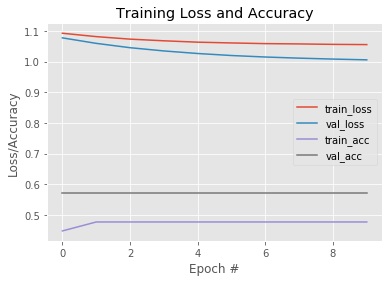

In [33]:
create_Bilstm_model_with_attention(glove_embedding_vector_dim, trainX, trainY, train_targetX, testX, testY, test_targetX)

# CNN model for Stance detection: (configuration 1)

In [18]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

def create_cnn_model(vector_dim, trainX, trainY, train_targetX, testX, testY, test_targetX):
    num_of_epochs = 20
    tf.keras.backend.clear_session()
    
    """
    One hot encoding the training and the test labels
    """
    trainY = tf.keras.utils.to_categorical(trainY, 3)
    testY = tf.keras.utils.to_categorical(testY, 3)
    """
    Defining 2 Input layers: one for target words and the other for tweet sentences 
    """
    target_seq_input_begin = Input(shape=(train_targetX.shape[1], train_targetX.shape[2]))
    train_tweet_seq_begin = Input(shape=(trainX.shape[1], trainX.shape[2]))
    """
    Convolutional layer 1 over target sentences 
    """
    target_activation = tf.keras.layers.Conv1D(filters=vector_dim, strides=1, kernel_size=2, padding='valid', activation=tf.nn.relu,
                                                                  input_shape=(train_targetX.shape[1],
                                                                  train_targetX.shape[2]))(target_seq_input_begin)
    
    """
    Max pooling layer over the output received from the convolutional unit number 1
    """
    maxpooling_op = tf.keras.layers.MaxPool1D()(target_activation)
    

    """
    Convolutional layer 2 over tweet sentences 
    """
    tweet_activation = tf.keras.layers.Conv1D(filters=vector_dim, strides=1, kernel_size=2, padding='valid', activation=tf.nn.relu,
                                                                  input_shape=(train_targetX.shape[1],
                                                                  train_targetX.shape[2]))(train_tweet_seq_begin)
    """
    Max pooling layer 2 over the output received from the convolutional unit number 2
    """
    maxpooling_op_1 = tf.keras.layers.MaxPool1D()(tweet_activation)
    
    """
    merging the output of the two CNN's by concatenating their output representations
    """
    merged = tf.keras.layers.concatenate([maxpooling_op, maxpooling_op_1])
    
    """
    Flattening the output of the merged layer
    """
    flattened_output = tf.keras.layers.Flatten()(merged)
    """
    Passing the flattened out through a multi-layered perceptron unit with softmax function as the output layer
    """
    MLP = tf.keras.layers.Dense(vector_dim, activation='relu')(flattened_output)
    dropout_layer_op = tf.keras.layers.Dropout(0.4)(MLP)
    MLP_1 = tf.keras.layers.Dense(100, activation='relu')(dropout_layer_op)
    dropout_layer_op_1 = tf.keras.layers.Dropout(0.4)(MLP_1)
    dense2 = tf.keras.layers.Dense(3, activation='softmax')(dropout_layer_op_1)
    
    model = Model(inputs=[target_seq_input_begin, train_tweet_seq_begin], outputs=dense2)
    model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=0.001), metrics=['accuracy'])
    print(model.summary())
    
    H = model.fit([train_targetX, trainX], trainY, 
          epochs=num_of_epochs, batch_size=32, 
          validation_data=([test_targetX, testX], testY))
    
    results = model.predict([test_targetX, testX])
    predictions = np.argmax(results, axis=1)
    testY = np.argmax(testY, axis=1)
    
    print("Final test data accuracy : ", accuracy_score(testY, predictions))
    print("F1 score : ", f1_score(testY, predictions, average='micro'))
    print("F1 score : ", f1_score(testY, predictions, average='macro'))
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, num_of_epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, num_of_epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, num_of_epochs), H.history["acc"], label="train_acc")
    plt.plot(np.arange(0, num_of_epochs), H.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 300)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50, 300)      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 49, 300)      180300      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 49, 300)      180300      input_2[0][0]                    
__________________________________________________________________________________________________
max_poolin

d:\research_project_for_thesis\venv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


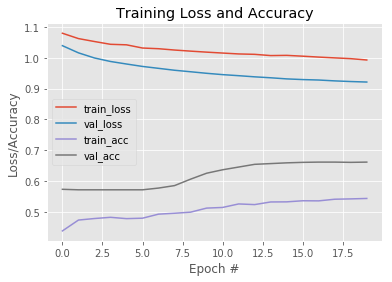

In [19]:
create_cnn_model(glove_embedding_vector_dim, trainX, trainY, train_targetX, testX, testY, test_targetX)

# CNN model for Stance detection: (configuration 2)

In [20]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

def create_cnn_config2_model(vector_dim, trainX, trainY, train_targetX, testX, testY, test_targetX):
    num_of_epochs = 30
    tf.keras.backend.clear_session()
    trainY = tf.keras.utils.to_categorical(trainY, 3)
    testY = tf.keras.utils.to_categorical(testY, 3)
    
    target_seq_input_begin = Input(shape=(train_targetX.shape[1], train_targetX.shape[2]))
    train_tweet_seq_begin = Input(shape=(trainX.shape[1], trainX.shape[2]))
    
    target_conv_1 = tf.keras.layers.Conv1D(filters=vector_dim, strides=1, kernel_size=2, padding='valid', activation=tf.nn.relu,
                                                                  input_shape=(train_targetX.shape[1],
                                                                  train_targetX.shape[2]))(target_seq_input_begin)
    target_conv_2 = tf.keras.layers.Conv1D(filters=vector_dim, strides=1, kernel_size=2, padding='valid', activation=tf.nn.relu)(target_conv_1)
    
    maxpooling_op = tf.keras.layers.MaxPool1D()(target_conv_2)
    

    tweet_conv_1 = tf.keras.layers.Conv1D(filters=vector_dim, strides=1, kernel_size=2, padding='valid', activation=tf.nn.relu,
                                                                  input_shape=(train_targetX.shape[1],
                                                                  train_targetX.shape[2]))(train_tweet_seq_begin)
    
    tweet_conv_2 = tf.keras.layers.Conv1D(filters=vector_dim, strides=1, kernel_size=2, padding='valid', activation=tf.nn.relu)(tweet_conv_1)
    
    maxpooling_op_1 = tf.keras.layers.MaxPool1D()(tweet_conv_2)
    
    merged = tf.keras.layers.concatenate([maxpooling_op, maxpooling_op_1])
    
    flattened_output = tf.keras.layers.Flatten()(merged)
    MLP = tf.keras.layers.Dense(vector_dim, activation='relu')(flattened_output)
    dropout_layer_op = tf.keras.layers.Dropout(0.4)(MLP)
    MLP_1 = tf.keras.layers.Dense(100, activation='relu')(dropout_layer_op)
    dropout_layer_op_1 = tf.keras.layers.Dropout(0.4)(MLP_1)
    dense2 = tf.keras.layers.Dense(3, activation='softmax')(dropout_layer_op_1)
    
    model = Model(inputs=[target_seq_input_begin, train_tweet_seq_begin], outputs=dense2)
    model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=0.001), metrics=['accuracy'])
    print(model.summary())
    
    H = model.fit([train_targetX, trainX], trainY, 
          epochs=num_of_epochs, 
          validation_data=([test_targetX, testX], testY))
    
    results = model.predict([test_targetX, testX])
    predictions = np.argmax(results, axis=1)
    testY = np.argmax(testY, axis=1)
    
    print("Final test data accuracy : ", accuracy_score(testY, predictions))
    print("F1 score : ", f1_score(testY, predictions, average='micro'))
    print("F1 score : ", f1_score(testY, predictions, average='macro'))
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, num_of_epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, num_of_epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, num_of_epochs), H.history["acc"], label="train_acc")
    plt.plot(np.arange(0, num_of_epochs), H.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 300)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50, 300)      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 49, 300)      180300      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 49, 300)      180300      input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (

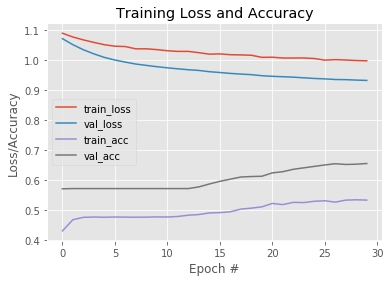

In [21]:
create_cnn_config2_model(glove_embedding_vector_dim, trainX, trainY, train_targetX, testX, testY, test_targetX)